In [35]:
import json
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, freqz

FS = 44100
def modified_biquad_kernel(x, y, i, a0, a1, a2, b1, b2, c0, d0):
    return (c0*a0+d0)*x[i] + (c0*a1+d0*b1)*x[i-1] + (c0*a2+d0*b2)*x[i-2] - b1*y[i-1] -b2*y[i-2]

## these are first order due to a0, b0 == 0
def first_order_low_shelf(sig, fc, gain, coeffs_only=False):
    # thanks to https://dsp.stackexchange.com/questions/90128/low-shelving-filter-frequency-response-diagnosis
    y = [0,0]
    x = sig
    # design equations
    theta_c = (2.*np.pi*fc)/FS
    mu = 10.**(gain/20.)
    beta = 4./(1.+mu)
    delta = beta*np.tan(theta_c/2.)
    gamma = (1-delta)/(1+delta)
    a0 = (1-gamma)/2
    a1 = a0
    a2 = 0.
    b1 = -gamma
    b2 = 0.
    c0 = mu - 1.
    d0 = 1.
    if coeffs_only:
        numerator   = [c0*a0+d0, c0*a1+d0*b1, c0*a2+d0*b2]
        denominator = [1, b1, b2]
        return numerator, denominator
    
    for i in range(2, len(sig)):
        yn = modified_biquad_kernel(x, y, i, a0, a1, a2, b1, b2, c0, d0)
        y.append(yn)
        
    return y


def first_order_high_shelf(sig, fc, gain, coeffs_only=False):
    y = [0,0]
    x = sig
    # design equations
    theta_c = (2.*np.pi*fc)/FS
    mu = 10.**(gain/20.)
    beta = (1.+mu)/4.
    delta = beta*np.tan(theta_c/2.)
    gamma = (1-delta)/(1+delta)
    a0 = (1+gamma)/2
    a1 = (-gamma-1)/2
    a2 = 0.
    b1 = -gamma
    b2 = 0.
    c0 = mu - 1.
    d0 = 1.
    if coeffs_only:
        numerator   = [c0*a0+d0, c0*a1+d0*b1, c0*a2+d0*b2]
        denominator = [1, b1, b2]
        return numerator, denominator
    
    for i in range(2, len(sig)):
        yn = modified_biquad_kernel(x, y, i, a0, a1, a2, b1, b2, c0, d0)
        y.append(yn)
        
    return y


def many_sin(freqs=np.linspace(1,1000,1000)):
    fs = 10000
    x = np.linspace(0,10000, fs)
    mat =  np.zeros((len(freqs), fs))
    for i, f in enumerate(freqs):
        mat[i] = np.sin(f*x)
        
    return mat.sum(0)

In [ ]:
filtered = first_order_low_shelf(signal, 100, -3)
for sig in (signal, filtered):
    frequencies, psd = welch(sig, FS, nperseg=2048)
    plt.semilogy(frequencies, psd)
plt.xlim(0,10000)
plt.xlabel('Frequency (Hz)')

Text(0, 0.5, 'gain (db)')

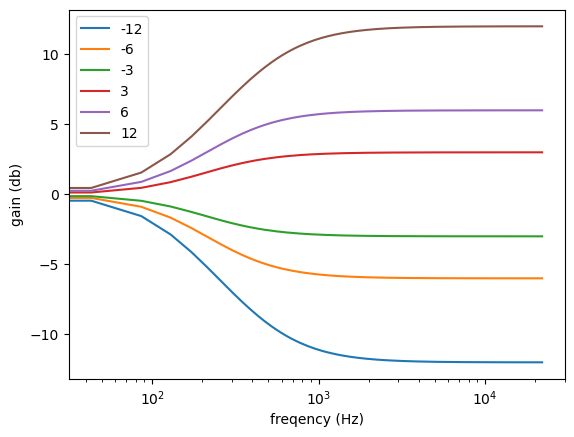

In [36]:
fc = 400
# db = 3
# for fc in np.arange(1000,20000,1000):
for db in [-12,-6,-3,3,6,12]:
    nums, denoms = first_order_high_shelf(None, fc, db, True)
    f, h = freqz(nums, denoms)
    gain = 20 * np.log10(abs(h))
    plt.semilogx(f*FS/(2*np.pi), gain, label=db)
plt.legend()
plt.xlabel('freqency (Hz)')
plt.ylabel('gain (db)')

    # plt.vlines(fc, ymin=min(h), ymax=max(h))

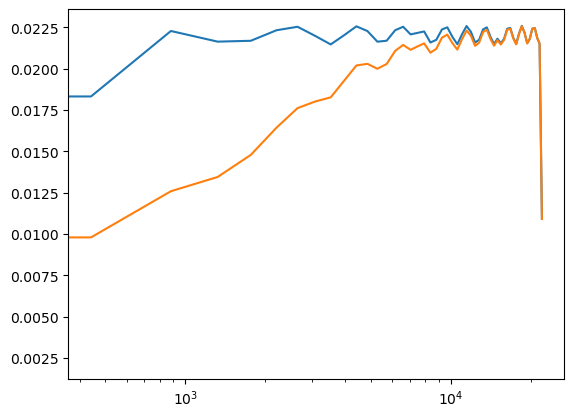

In [28]:
sig = many_sin() #np.random.normal(size=100000)
filtered = first_order_low_shelf(sig, 1000, -3)
frequencies, psd = welch(sig, FS, nperseg=100)
plt.semilogx(frequencies, psd)
frequencies, psd = welch(filtered, FS, nperseg=100)
plt.semilogx(frequencies, psd)


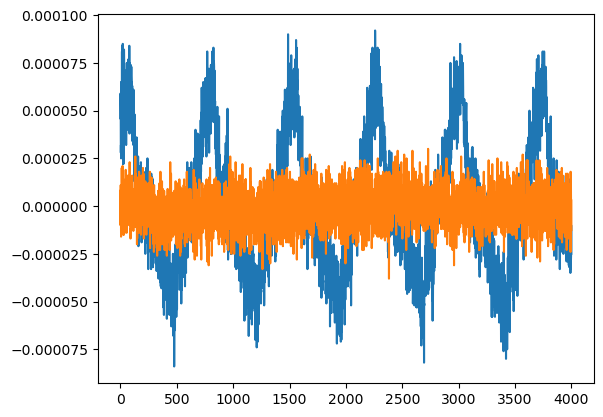

In [31]:
with open('test.json', 'r') as f:
    data = np.array(json.load(f))
    signal  = data[:,0][300:10000]

plt.plot(data[12000:16000])